# Train on Depth
reference from 

https://github.com/asap-report/carla/blob/racetrack/PythonClient/racetrack/train_on_depth.py
https://github.com/ManajitPal/DeepLearningForSelfDrivingCars/blob/master/self_driving_car.py

### Imports


In [3]:
%matplotlib inline 

import torch.nn as nn
from pathlib import Path
import numpy as np 
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image

#### Check if data exist

In [4]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/custom")
left_depth_dir = data_dir / "left"
center_depth_dir = data_dir / "center"
right_depth_dir = data_dir / "right"
veh_state_dir = data_dir / "state"

assert data_dir.exists(), "data dir does not exist"
assert left_depth_dir.exists(), "left_depth_dir does not exist"
assert center_depth_dir.exists(), "left_depth_dir does not exist"
assert right_depth_dir.exists(), "left_depth_dir does not exist"
assert veh_state_dir.exists(), "veh_state_dir does not exist"

left_depth_paths = [p for p in sorted(left_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
right_depth_paths = [p for p in sorted(right_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]

assert len(left_depth_paths) == len(center_depth_paths)== len(right_depth_paths)==len(veh_state_paths), "not the same size of X and y"
print(f"Found { len(left_depth_paths)} data points")

Found 981 data points


In [5]:
print(left_depth_paths[0])
print(center_depth_paths[0])
print(right_depth_paths[0])
print(veh_state_paths[0])

/home/michael/Desktop/projects/ROAR/data/custom/left/frame_09_19_2021_22_12_07_265034.npy
/home/michael/Desktop/projects/ROAR/data/custom/center/frame_09_19_2021_22_12_07_265034.npy
/home/michael/Desktop/projects/ROAR/data/custom/right/frame_09_19_2021_22_12_07_265034.npy
/home/michael/Desktop/projects/ROAR/data/custom/state/frame_09_19_2021_22_12_07_265034.npy


/home/michael/anaconda3/envs/ROAR/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'steering'}>,
        <AxesSubplot:title={'center':'throttle'}>]], dtype=object)

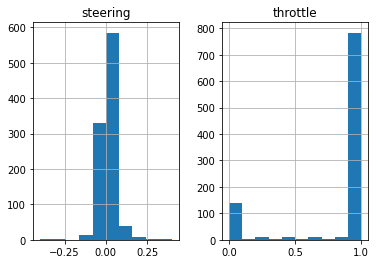

In [6]:
throttles, steerings = [], []
for st_path in veh_state_paths:
    array = np.load(st_path)
    throttles.append(array[-2])
    steerings.append(array[-1])
df = pd.DataFrame(
    data={"throttle":throttles, "steering":steerings}
)
df.hist()

### TODO: Do data augmentation

Let's only train on steering


### Define model

In [7]:
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader
import torch

In [8]:
class Dataset(data.Dataset):

    def __init__(self, samples, left_depth_dir, center_depth_dir, right_depth_dir, state_dir, transform=None):

        self.samples = samples
        self.transform = transform
        self.left_depth_dir: Path = left_depth_dir
        self.right_depth_dir: Path = right_depth_dir
        self.center_depth_dir: Path = center_depth_dir
        self.state_dir: Path = state_dir

    def __getitem__(self, index):
      
        sample_path = self.samples[index]
        left_depth_path = self.left_depth_dir / sample_path
        center_depth_path = self.center_depth_dir / sample_path
        right_depth_path = self.right_depth_dir / sample_path
        veh_state_path = self.state_dir / sample_path
        
        left_depth = np.load(left_depth_path)
        right_depth = np.load(left_depth_path)
        center_depth = np.load(right_depth_path)
        veh_state = np.load(veh_state_path)
        
        steering_angle_center = veh_state[-1]
        steering_angle_left = steering_angle_center + 0.2
        steering_angle_right = steering_angle_center - 0.2
        return (center_depth, steering_angle_center), \
               (left_depth, steering_angle_left), \
               (right_depth, steering_angle_right)
      
    def __len__(self):
        return len(self.samples)


In [9]:
params = {'batch_size': 1,
          'shuffle': True,
          'num_workers': 4}
samples = [Path(p).name for p in veh_state_paths]
samples = samples[:len(samples) - len(samples)%params['batch_size'] ]
dataset = Dataset(samples=samples, 
                  left_depth_dir = left_depth_dir, 
                  center_depth_dir=center_depth_dir, 
                  right_depth_dir=right_depth_dir,
                  state_dir = veh_state_dir)
data_generator = data.DataLoader(dataset, **params)


In [10]:
# Step6: Check the device and define function to move tensors to that device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print('device is: ', device)

def toDevice(datas, device):
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)
def to_tensor(datas, device):
    imgs, angles = datas
    return imgs.float().to(device), angles.float().to(device)


device is:  cuda


In [11]:
class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.25),
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=404736, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )
        
    def forward(self, input):  
        input = input.view(input.size(0), 1, 600, 800)
        output = self.conv_layers(input)
        output = torch.flatten(output)
        output = self.linear_layers(output)
        return output
model = NvidiaModel()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [13]:
for epoch in range(10):
    print(f"Staring Epoch {epoch}")
    model.to(device)
    train_loss = 0
    model.train()
    counter = 0
    for i, (centers, lefts, rights) in enumerate(data_generator):
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)
        optimizer.zero_grad()
        datas = [centers, lefts, rights]
        for data in datas:
            imgs, angles = data
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))
            loss.backward()
            optimizer.step()
            
            train_loss += loss.data.item()
            
        if i % 100 == 0:
            print(f"    At iteration {i} -> loss: {train_loss / (i+1)}")
    

Staring Epoch 0
    At iteration 0 -> loss: 2.1784337796270847


/home/michael/anaconda3/envs/ROAR/lib/python3.7/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


    At iteration 10 -> loss: 6.213915099186124
    At iteration 20 -> loss: 7.575714926206274
    At iteration 30 -> loss: 8.471685166059615
    At iteration 40 -> loss: 9.481662773174321
    At iteration 50 -> loss: 10.3687939569445
    At iteration 60 -> loss: 11.244889974019316
    At iteration 70 -> loss: 12.360507460776716
    At iteration 80 -> loss: 13.545927020342788
    At iteration 90 -> loss: 14.35728020343413
    At iteration 100 -> loss: 15.285666734214828
    At iteration 110 -> loss: 16.2659329703107
    At iteration 120 -> loss: 17.19391660254007
    At iteration 130 -> loss: 18.031216289120152
    At iteration 140 -> loss: 18.968936674743986
    At iteration 150 -> loss: 20.02398940302794
    At iteration 160 -> loss: 20.95330499169779
    At iteration 170 -> loss: 22.15693573006837
    At iteration 180 -> loss: 22.986620772059666
    At iteration 190 -> loss: 24.20127797743004
    At iteration 200 -> loss: 25.041450888359634
    At iteration 210 -> loss: 25.8855405361

    At iteration 720 -> loss: 66.08289101267326
    At iteration 730 -> loss: 67.19314539369987
    At iteration 740 -> loss: 68.07356183675827
    At iteration 750 -> loss: 68.93350549194136
    At iteration 760 -> loss: 69.81192427034446
    At iteration 770 -> loss: 70.6823906960357
    At iteration 780 -> loss: 71.54184498501346
    At iteration 790 -> loss: 72.42136956904724
    At iteration 800 -> loss: 73.33304774207309
    At iteration 810 -> loss: 74.20983778239125
    At iteration 820 -> loss: 75.07331753346799
    At iteration 830 -> loss: 76.44243993307876
    At iteration 840 -> loss: 77.36910515082806
    At iteration 850 -> loss: 78.2107460913289
    At iteration 860 -> loss: 79.08015812380697
    At iteration 870 -> loss: 79.92616250716296
    At iteration 880 -> loss: 80.824210193943
    At iteration 890 -> loss: 81.72626379423659
    At iteration 900 -> loss: 82.5961493437679
    At iteration 910 -> loss: 83.50376756974569
    At iteration 920 -> loss: 84.403771111045

    At iteration 440 -> loss: 39.320854484929185
    At iteration 450 -> loss: 40.24665844973035
    At iteration 460 -> loss: 41.117827001427685
    At iteration 470 -> loss: 41.97375926894867
    At iteration 480 -> loss: 42.8723229469758
    At iteration 490 -> loss: 44.25165361493757
    At iteration 500 -> loss: 45.12155214925661
    At iteration 510 -> loss: 46.00085604090855
    At iteration 520 -> loss: 46.86907171783448
    At iteration 530 -> loss: 47.734456435437345
    At iteration 540 -> loss: 48.59159002097501
    At iteration 550 -> loss: 49.46926296800509
    At iteration 560 -> loss: 50.32514085631035
    At iteration 570 -> loss: 51.17560771245032
    At iteration 580 -> loss: 52.77315549978109
    At iteration 590 -> loss: 53.64783930789351
    At iteration 600 -> loss: 54.54233345297441
    At iteration 610 -> loss: 55.424175097444525
    At iteration 620 -> loss: 56.74289724285088
    At iteration 630 -> loss: 57.781232876373245
    At iteration 640 -> loss: 58.625

    At iteration 160 -> loss: 14.476053221093665
    At iteration 170 -> loss: 15.341022641989824
    At iteration 180 -> loss: 16.198134416927772
    At iteration 190 -> loss: 17.06788178905795
    At iteration 200 -> loss: 17.923093800541622
    At iteration 210 -> loss: 18.983741345504725
    At iteration 220 -> loss: 19.84249544383279
    At iteration 230 -> loss: 20.719975479988037
    At iteration 240 -> loss: 21.611680185506387
    At iteration 250 -> loss: 22.4588642009589
    At iteration 260 -> loss: 23.32227549350212
    At iteration 270 -> loss: 24.42025042155167
    At iteration 280 -> loss: 25.362979412182383
    At iteration 290 -> loss: 26.192025716389097
    At iteration 300 -> loss: 27.053723754333316
    At iteration 310 -> loss: 27.893650177983783
    At iteration 320 -> loss: 28.755012954542746
    At iteration 330 -> loss: 29.62198884418218
    At iteration 340 -> loss: 30.470256705630288
    At iteration 350 -> loss: 31.398054224446366
    At iteration 360 -> los

    At iteration 870 -> loss: 79.78166817677221
    At iteration 880 -> loss: 80.6532128435497
    At iteration 890 -> loss: 81.49659543200808
    At iteration 900 -> loss: 82.37534198202896
    At iteration 910 -> loss: 83.23007997477664
    At iteration 920 -> loss: 84.09389960707752
    At iteration 930 -> loss: 84.97817911818068
    At iteration 940 -> loss: 85.82787378894075
    At iteration 950 -> loss: 86.68945833413484
    At iteration 960 -> loss: 87.56553324876229
    At iteration 970 -> loss: 88.43924914521274
    At iteration 980 -> loss: 89.31355457646357
Staring Epoch 7
    At iteration 0 -> loss: 0.08491190988570452
    At iteration 10 -> loss: 0.9253234866446292
    At iteration 20 -> loss: 1.7796572095162009
    At iteration 30 -> loss: 3.4432699849625825
    At iteration 40 -> loss: 4.277547312330582
    At iteration 50 -> loss: 5.148351403452991
    At iteration 60 -> loss: 5.9913262325419
    At iteration 70 -> loss: 6.889002527800762
    At iteration 80 -> loss: 7.

    At iteration 590 -> loss: 54.12999848431286
    At iteration 600 -> loss: 54.993153573515194
    At iteration 610 -> loss: 55.885937073545435
    At iteration 620 -> loss: 56.76033731082957
    At iteration 630 -> loss: 57.67215807928828
    At iteration 640 -> loss: 58.68311557459769
    At iteration 650 -> loss: 59.63169033779654
    At iteration 660 -> loss: 61.03483697655149
    At iteration 670 -> loss: 61.94875870447383
    At iteration 680 -> loss: 62.84062164387676
    At iteration 690 -> loss: 63.68393437193542
    At iteration 700 -> loss: 64.5827504841315
    At iteration 710 -> loss: 65.49627830621164
    At iteration 720 -> loss: 66.46045057390863
    At iteration 730 -> loss: 67.32967301116211
    At iteration 740 -> loss: 68.21442308453031
    At iteration 750 -> loss: 69.08842097665972
    At iteration 760 -> loss: 69.99474289217385
    At iteration 770 -> loss: 70.87731260758362
    At iteration 780 -> loss: 71.74315622636702
    At iteration 790 -> loss: 72.611420

In [14]:
model.eval()
valid_loss = 0
with torch.set_grad_enabled(False):
    for local_batch, (centers, lefts, rights) in enumerate(data_generator):
        # Transfer to GPU
        centers, lefts, rights = toDevice(centers, device), toDevice(lefts, device), toDevice(rights, device)

        # Model computations
        optimizer.zero_grad()
        datas = [centers, lefts, rights]        
        for data in datas:
            imgs, angles = data
            outputs = model(imgs)
            loss = criterion(outputs, angles.unsqueeze(1))

            valid_loss += loss.data.item()

        if local_batch % 10 == 0:
            print('Valid Loss: %.3f '
                 % (valid_loss/(local_batch+1)))

Valid Loss: 0.085 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.096 
Valid Loss: 0.095 
Valid Loss: 0.093 
Valid Loss: 0.092 
Valid Loss: 0.091 
Valid Loss: 0.091 
Valid Loss: 0.091 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.088 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.089 
Valid Loss: 0.090 
Valid Loss: 0.089 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 0.090 
Valid Loss: 

In [15]:
# Step8: Define state and save the model wrt to state
# state = {
#         'model': model.module if device == 'cuda' else model,
#         }

# torch.save(state, 'model.h5')
torch.save(model, 'model.h5')
# torch.save(model.state_dict(), 'state_dict.h5')